In [10]:
!pip install optuna
!pip install pytorch-lightning
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_step_v2.pickle', 'rb') as f:
    data = pickle.load(f)

# drop_col = ['keyword']
# res_data = data.drop(drop_col, axis=1)
# data['keyword'] = data['keyword'].str.replace("<"," ")
res_data = data.copy()
res_data['date'] = pd.to_datetime(res_data['date'], format='%Y-%m-%d')
res_data = res_data.sort_values('date').reset_index(drop=True)
res_data['time_index'] = np.arange(len(data))
res_data['time_index'] = res_data['time_index'].astype(int)
res_data['dominant_topic'] = res_data['dominant_topic'].astype(str).astype("category")

# GroupNormalizer
gn = GroupNormalizer(
    groups= ['market'],
    scale_by_group = True,
    transformation="softplus"
)

res_data_columns = res_data.drop(columns=['date','market', 'time_index', 'kr_holiday','us_holiday','dayofweek','month','dominant_topic'], axis=1).columns
for n, i in enumerate(res_data_columns):
    # if n < 3:
    # print(i)
    globals()['scaled_{}'.format(i)] = gn.fit_transform(res_data[i], res_data, return_norm = True)
    res_data[i] = globals()['scaled_{}'.format(i)][0]

In [15]:
def objective(trial):

    cfg = { 'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 1e-0),
            'max_epochs' : trial.suggest_int('max_epochs', 50, 151),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 1e-0),
            'weight_decay' : trial.suggest_float('weight_decay', 1e-3, 1e-0),
            'backcast_loss_ratio' : trial.suggest_float('backcast_loss_ratio', 0.1, 1.0),
            'trend_block_size' : trial.suggest_categorical('trend_block_size', [16,32,64,128,256]),
            'seasonality_block_size' : trial.suggest_categorical('seasonality_block_size', [64,128,256,512])
            }

    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 90
    max_prediction_length = 20

    training_cutoff = res_data['time_index'].max() - max_prediction_length

    context_length = max_encoder_length
    prediction_length = max_prediction_length

    training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="trade_price",
        categorical_encoders={"market": NaNLabelEncoder().fit(res_data.market)},
        group_ids=["market"],
        # only unknown variable is "value" - and N-Beats can also not take any additional variables
        # time_varying_known_categoricals=['dayofweek', 'month','kr_holiday', 'us_holiday'],
        # time_varying_known_reals=["time_index"],
        # time_varying_unknown_categoricals=["dominant_topic"],     
        time_varying_unknown_reals=["trade_price"],
        max_encoder_length = context_length,
        max_prediction_length = prediction_length,
        allow_missing_timesteps = False
    )

    validation = TimeSeriesDataSet.from_dataset(
        training, 
        res_data, 
        min_prediction_idx = training_cutoff + 1,
        predict=True,
        stop_randomization=True
    )


    batch_size = 128 
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    # calculate smape
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()

    print(f'mae_with_baseline : {mae_with_baseline}')


    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    # logger = TensorBoardLogger("./lightning_logs/NBeats")  # logging results to a tensorboard


    trainer = pl.Trainer(
        max_epochs = cfg['max_epochs'],
        gpus = 1,
        weights_summary = 'top',
        gradient_clip_val = 0.01,
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  30, # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        enable_checkpointing = True,
        auto_lr_find = True
        # logger=logger
    )

    trend_block_size = cfg['trend_block_size']
    seasonality_block_size = cfg['seasonality_block_size']

    net = NBeats.from_dataset(
        training,
        # architecture hyperparameters
        learning_rate = cfg['learning_rate'],
        log_interval = 10,
        log_val_interval = 1,
        weight_decay= cfg['weight_decay'],
        widths=[trend_block_size, seasonality_block_size],
        backcast_loss_ratio=cfg['backcast_loss_ratio']
    )     
    print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

    # fit network
    trainer.fit(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


    #### Evaluate performance

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = NBeats.load_from_checkpoint(best_model_path)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)


    SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()
    print(SMAPE)

    # (actuals - predictions).abs().mean()

    return SMAPE

In [16]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(objective, n_trials=25)


[I 2022-06-15 14:08:30,370] A new study created in memory with name: no-name-1b965961-24d6-4333-b48b-d9a368f065ce
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs


mae_with_baseline : 0.45236268639564514
Number of parameters in network: 615.2k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 615 K 
-----------------------------------------------
615 K     Trainable params
0         Non-trainable params
615 K     Total params
2.461     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:11:20,602] Trial 0 finished with value: 0.42359909415245056 and parameters: {'learning_rate': 0.0032891085890338926, 'max_epochs': 79, 'gradient_clip_val': 0.010104736861147457, 'weight_decay': 0.41806608486534597, 'backcast_loss_ratio': 0.11652942189696794, 'trend_block_size': 128, 'seasonality_block_size': 256}. Best is trial 0 with value: 0.42359909415245056.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4236)
mae_with_baseline : 0.45236268639564514
Number of parameters in network: 276.9k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 276 K 
-----------------------------------------------
276 K     Trainable params
0         Non-trainable params
276 K     Total params
1.107     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:12:55,206] Trial 1 finished with value: 0.4363899827003479 and parameters: {'learning_rate': 0.025134152260542157, 'max_epochs': 106, 'gradient_clip_val': 0.016785198642959073, 'weight_decay': 0.3073581296257267, 'backcast_loss_ratio': 0.18219793746708418, 'trend_block_size': 128, 'seasonality_block_size': 128}. Best is trial 0 with value: 0.42359909415245056.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4364)
mae_with_baseline : 0.45236268639564514
Number of parameters in network: 513.2k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 513 K 
-----------------------------------------------
513 K     Trainable params
0         Non-trainable params
513 K     Total params
2.053     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:14:49,515] Trial 2 finished with value: 0.4356852173805237 and parameters: {'learning_rate': 0.008071971340167797, 'max_epochs': 104, 'gradient_clip_val': 0.19512007628393105, 'weight_decay': 0.7472996808043839, 'backcast_loss_ratio': 0.17540017545551306, 'trend_block_size': 256, 'seasonality_block_size': 64}. Best is trial 0 with value: 0.42359909415245056.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4357)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.9 M 
-----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.526     Total estimated model params size (MB)


Number of parameters in network: 1881.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:16:01,718] Trial 3 finished with value: 0.47185420989990234 and parameters: {'learning_rate': 0.047277277360265255, 'max_epochs': 51, 'gradient_clip_val': 0.016489352481861737, 'weight_decay': 0.9524564843527471, 'backcast_loss_ratio': 0.8392853504561942, 'trend_block_size': 128, 'seasonality_block_size': 512}. Best is trial 0 with value: 0.42359909415245056.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4719)
mae_with_baseline : 0.45236268639564514
Number of parameters in network: 486.1k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 486 K 
-----------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.945     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:16:40,107] Trial 4 finished with value: 0.5508671998977661 and parameters: {'learning_rate': 0.00012109814966014467, 'max_epochs': 74, 'gradient_clip_val': 0.0067618035665441495, 'weight_decay': 0.14548173642368842, 'backcast_loss_ratio': 0.9560419143911769, 'trend_block_size': 16, 'seasonality_block_size': 256}. Best is trial 0 with value: 0.42359909415245056.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.5509)
mae_with_baseline : 0.45236268639564514
Number of parameters in network: 946.9k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 946 K 
-----------------------------------------------
946 K     Trainable params
0         Non-trainable params
946 K     Total params
3.788     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:18:11,636] Trial 5 finished with value: 0.5836669206619263 and parameters: {'learning_rate': 0.8153239899357293, 'max_epochs': 94, 'gradient_clip_val': 0.0008868651650268942, 'weight_decay': 0.6122240391627458, 'backcast_loss_ratio': 0.5974935304660506, 'trend_block_size': 256, 'seasonality_block_size': 256}. Best is trial 0 with value: 0.42359909415245056.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.5837)
mae_with_baseline : 0.45236268639564514
Number of parameters in network: 523.0k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 523 K 
-----------------------------------------------
523 K     Trainable params
0         Non-trainable params
523 K     Total params
2.092     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:21:11,325] Trial 6 finished with value: 0.4055485725402832 and parameters: {'learning_rate': 0.0017150877533674426, 'max_epochs': 93, 'gradient_clip_val': 0.00619150803156783, 'weight_decay': 0.6008995513141882, 'backcast_loss_ratio': 0.7945349190826567, 'trend_block_size': 64, 'seasonality_block_size': 256}. Best is trial 6 with value: 0.4055485725402832.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4055)
mae_with_baseline : 0.45236268639564514
Number of parameters in network: 513.2k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 513 K 
-----------------------------------------------
513 K     Trainable params
0         Non-trainable params
513 K     Total params
2.053     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:22:53,736] Trial 7 finished with value: 0.4831296503543854 and parameters: {'learning_rate': 0.11753810642864874, 'max_epochs': 125, 'gradient_clip_val': 0.000148882200873975, 'weight_decay': 0.8413348676145266, 'backcast_loss_ratio': 0.8053959331136313, 'trend_block_size': 256, 'seasonality_block_size': 64}. Best is trial 6 with value: 0.4055485725402832.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4831)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 276 K 
-----------------------------------------------
276 K     Trainable params
0         Non-trainable params
276 K     Total params
1.107     Total estimated model params size (MB)


Number of parameters in network: 276.9k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:24:43,638] Trial 8 finished with value: 0.4861930012702942 and parameters: {'learning_rate': 0.14903746541404753, 'max_epochs': 81, 'gradient_clip_val': 0.028995406753453367, 'weight_decay': 0.9858908935755447, 'backcast_loss_ratio': 0.59384334132914, 'trend_block_size': 128, 'seasonality_block_size': 128}. Best is trial 6 with value: 0.4055485725402832.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 61.6 K
-----------------------------------------------
61.6 K    Trainable params
0         Non-trainable params
61.6 K    Total params
0.247     Total estimated model params size (MB)


tensor(0.4862)
mae_with_baseline : 0.45236268639564514
Number of parameters in network: 61.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:25:38,517] Trial 9 finished with value: 0.49599510431289673 and parameters: {'learning_rate': 0.42860466646695666, 'max_epochs': 95, 'gradient_clip_val': 0.01121366167271827, 'weight_decay': 0.5206828405705193, 'backcast_loss_ratio': 0.585537478218085, 'trend_block_size': 32, 'seasonality_block_size': 64}. Best is trial 6 with value: 0.4055485725402832.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4960)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.158     Total estimated model params size (MB)


Number of parameters in network: 1789.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:29:04,988] Trial 10 finished with value: 0.39665287733078003 and parameters: {'learning_rate': 0.0006920921058558366, 'max_epochs': 148, 'gradient_clip_val': 0.310810709671778, 'weight_decay': 0.13576656294481682, 'backcast_loss_ratio': 0.3858942941995938, 'trend_block_size': 64, 'seasonality_block_size': 512}. Best is trial 10 with value: 0.39665287733078003.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3967)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.158     Total estimated model params size (MB)


Number of parameters in network: 1789.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:32:18,898] Trial 11 finished with value: 0.40120020508766174 and parameters: {'learning_rate': 0.0007305821773623738, 'max_epochs': 149, 'gradient_clip_val': 0.6830763372586883, 'weight_decay': 0.02006101570387181, 'backcast_loss_ratio': 0.3693413072637231, 'trend_block_size': 64, 'seasonality_block_size': 512}. Best is trial 10 with value: 0.39665287733078003.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4012)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.158     Total estimated model params size (MB)


Number of parameters in network: 1789.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:36:49,923] Trial 12 finished with value: 0.3967403769493103 and parameters: {'learning_rate': 0.0004993359512972243, 'max_epochs': 151, 'gradient_clip_val': 0.8634959127970862, 'weight_decay': 0.07666052894007885, 'backcast_loss_ratio': 0.3701795440930925, 'trend_block_size': 64, 'seasonality_block_size': 512}. Best is trial 10 with value: 0.39665287733078003.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3967)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.158     Total estimated model params size (MB)


Number of parameters in network: 1789.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:37:29,044] Trial 13 finished with value: 0.5509082674980164 and parameters: {'learning_rate': 0.00022692369863182822, 'max_epochs': 151, 'gradient_clip_val': 0.8979284617895921, 'weight_decay': 0.19148838078318203, 'backcast_loss_ratio': 0.3991111056649773, 'trend_block_size': 64, 'seasonality_block_size': 512}. Best is trial 10 with value: 0.39665287733078003.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.5509)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.158     Total estimated model params size (MB)


Number of parameters in network: 1789.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:41:32,587] Trial 14 finished with value: 0.39490312337875366 and parameters: {'learning_rate': 0.0005392060858612278, 'max_epochs': 133, 'gradient_clip_val': 0.12336543061288598, 'weight_decay': 0.02436528295366324, 'backcast_loss_ratio': 0.3843948250537812, 'trend_block_size': 64, 'seasonality_block_size': 512}. Best is trial 14 with value: 0.39490312337875366.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3949)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.158     Total estimated model params size (MB)


Number of parameters in network: 1789.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:44:28,454] Trial 15 finished with value: 0.4160343110561371 and parameters: {'learning_rate': 0.0018194331656195648, 'max_epochs': 130, 'gradient_clip_val': 0.11843448264418491, 'weight_decay': 0.28916666530447843, 'backcast_loss_ratio': 0.4575952404445092, 'trend_block_size': 64, 'seasonality_block_size': 512}. Best is trial 14 with value: 0.39490312337875366.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4160)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:49:23,725] Trial 16 finished with value: 0.3807743489742279 and parameters: {'learning_rate': 0.00039144866231302406, 'max_epochs': 134, 'gradient_clip_val': 0.10495772614973596, 'weight_decay': 0.23616013783994438, 'backcast_loss_ratio': 0.2715414646685181, 'trend_block_size': 32, 'seasonality_block_size': 512}. Best is trial 16 with value: 0.3807743489742279.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3808)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:50:03,221] Trial 17 finished with value: 0.5920606851577759 and parameters: {'learning_rate': 0.00010177790066039176, 'max_epochs': 128, 'gradient_clip_val': 0.06390584508569658, 'weight_decay': 0.30094152672256624, 'backcast_loss_ratio': 0.26619622730491266, 'trend_block_size': 32, 'seasonality_block_size': 512}. Best is trial 16 with value: 0.3807743489742279.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.5921)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:52:19,605] Trial 18 finished with value: 0.4337157607078552 and parameters: {'learning_rate': 0.0067284142298997, 'max_epochs': 115, 'gradient_clip_val': 0.06486355587831794, 'weight_decay': 0.40542716457935696, 'backcast_loss_ratio': 0.28121049416039795, 'trend_block_size': 32, 'seasonality_block_size': 512}. Best is trial 16 with value: 0.3807743489742279.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4337)
mae_with_baseline : 0.45236268639564514
Number of parameters in network: 147.8k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 147 K 
-----------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.591     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:52:57,081] Trial 19 finished with value: 0.572275698184967 and parameters: {'learning_rate': 0.0003349157912087704, 'max_epochs': 136, 'gradient_clip_val': 0.0033496762339889187, 'weight_decay': 0.21919883908935986, 'backcast_loss_ratio': 0.48984792943112465, 'trend_block_size': 16, 'seasonality_block_size': 128}. Best is trial 16 with value: 0.3807743489742279.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.5723)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:55:49,889] Trial 20 finished with value: 0.3965812027454376 and parameters: {'learning_rate': 0.0016457969026000996, 'max_epochs': 117, 'gradient_clip_val': 0.048576583205043565, 'weight_decay': 0.015592780097220905, 'backcast_loss_ratio': 0.27433899370876996, 'trend_block_size': 32, 'seasonality_block_size': 512}. Best is trial 16 with value: 0.3807743489742279.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3966)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 14:59:14,172] Trial 21 finished with value: 0.40545767545700073 and parameters: {'learning_rate': 0.0011367655478970132, 'max_epochs': 117, 'gradient_clip_val': 0.075516664749066, 'weight_decay': 0.002316863440683421, 'backcast_loss_ratio': 0.2727037359278892, 'trend_block_size': 32, 'seasonality_block_size': 512}. Best is trial 16 with value: 0.3807743489742279.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4055)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 15:01:20,884] Trial 22 finished with value: 0.4098007082939148 and parameters: {'learning_rate': 0.003012164691196417, 'max_epochs': 139, 'gradient_clip_val': 0.3056856188049779, 'weight_decay': 0.05804829325957969, 'backcast_loss_ratio': 0.23797312597686382, 'trend_block_size': 32, 'seasonality_block_size': 512}. Best is trial 16 with value: 0.3807743489742279.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.4098)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 15:02:00,362] Trial 23 finished with value: 0.5798173546791077 and parameters: {'learning_rate': 0.00030053147888338383, 'max_epochs': 117, 'gradient_clip_val': 0.05512279050362802, 'weight_decay': 0.11779730774738487, 'backcast_loss_ratio': 0.500327702399914, 'trend_block_size': 32, 'seasonality_block_size': 512}. Best is trial 16 with value: 0.3807743489742279.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.5798)
mae_with_baseline : 0.45236268639564514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-15 15:04:13,825] Trial 24 finished with value: 0.4018500745296478 and parameters: {'learning_rate': 0.0037508203354782283, 'max_epochs': 140, 'gradient_clip_val': 0.032651736476427044, 'weight_decay': 0.22314224001023392, 'backcast_loss_ratio': 0.10383491524855273, 'trend_block_size': 32, 'seasonality_block_size': 512}. Best is trial 16 with value: 0.3807743489742279.


tensor(0.4019)


In [18]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/NBeats_optuna_step_220615_01.pkl')
joblib.dump(study, '/content/NBeats_optuna.pkl')

['/content/NBeats_optuna.pkl']

In [ ]:
# study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/DeepAR_optuna_pca_220614_01.pkl")
study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/NBeats_optuna_step_220615_01.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

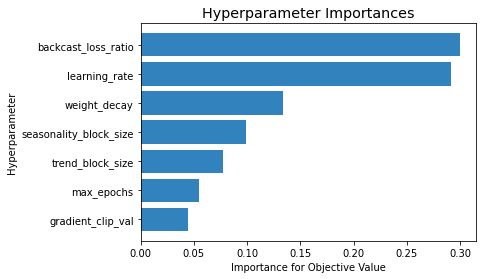

In [19]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

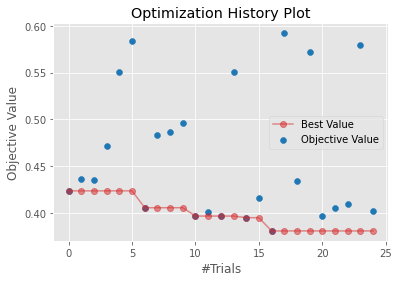



Number of finished trials:  25
Best trial:
  Value:  0.3807743489742279
  Params: 
    learning_rate: 0.00039144866231302406
    max_epochs: 134
    gradient_clip_val: 0.10495772614973596
    weight_decay: 0.23616013783994438
    backcast_loss_ratio: 0.2715414646685181
    trend_block_size: 32
    seasonality_block_size: 512


In [20]:
# show best hyperparameters
# print(study.best_trial.params)
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()
print("\n")


print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/NBeats/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.047     Total estimated model params size (MB)


mae_with_baseline : 0.45236268639564514
Number of parameters in network: 1761.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

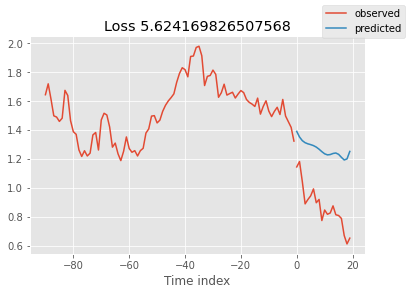

In [21]:
torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 90
max_prediction_length = 20

training_cutoff = res_data['time_index'].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    res_data[lambda x: x.time_index <= training_cutoff],
    time_idx="time_index",
    target="trade_price",
    categorical_encoders={"market": NaNLabelEncoder().fit(res_data.market)},
    group_ids=["market"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    # time_varying_known_categoricals=['dayofweek', 'month','kr_holiday', 'us_holiday'],
    # time_varying_known_reals=["time_index"],
    # time_varying_unknown_categoricals=["dominant_topic"],     
    time_varying_unknown_reals=["trade_price"],
    max_encoder_length = context_length,
    max_prediction_length = prediction_length,
    allow_missing_timesteps = False
)

validation = TimeSeriesDataSet.from_dataset(
    training, 
    res_data, 
    min_prediction_idx = training_cutoff + 1,
    predict=True,
    stop_randomization=True
)


batch_size = 128 
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
# calculate smape
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()

print(f'mae_with_baseline : {mae_with_baseline}')


# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("./lightning_logs/NBeats")  # logging results to a tensorboard


trainer = pl.Trainer(
    max_epochs = study.best_params['max_epochs'],
    gpus = 1,
    weights_summary = 'top',
    gradient_clip_val = 0.01,
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  30, # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    enable_checkpointing = True,
    auto_lr_find = True,
    logger=logger
)

trend_block_size = study.best_params['trend_block_size']
seasonality_block_size = study.best_params['seasonality_block_size']

net = NBeats.from_dataset(
    training,
    # architecture hyperparameters
    learning_rate = study.best_params['learning_rate'],
    log_interval = 10,
    log_val_interval = 1,
    weight_decay= study.best_params['weight_decay'],
    widths=[trend_block_size, seasonality_block_size],
    backcast_loss_ratio=study.best_params['backcast_loss_ratio']
)     
print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

# fit network
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = net.load_from_checkpoint(best_model_path)

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);


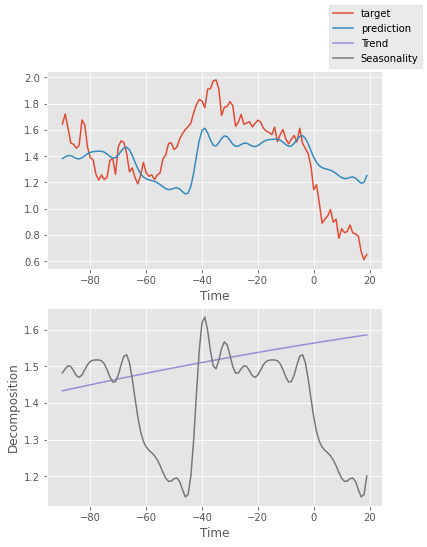

In [22]:
for idx in range(1):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx);

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/